In [37]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = False
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [38]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:169: ResourceWarning: unclosed <socket.socket fd=201, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41091 instead
  warnings.warn(


In [39]:
# Parameters
# mesh_path = '/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'amoc'
year      = [1958,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr, cnum  = 'blue2red', 15
cref, crange, cmin, cmax, cfac, climit = 0.0, None, None, None, None, None
chist, ctresh = True, 0.995

ref_cstr, ref_cnum = 'wbgyr', 15
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = 0.0, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995

#_____________________________________________________________________________________
which_lat         = 26.5 # 'max' # 'max', 26.0
ncol              = 2      # number of pannel columns in figure
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
do_enum           = False  # do enumeration of panels
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True #True/False
do_rapid          = False

In [40]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
    
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0   

#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])        
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
        
#______________________________________________________________________________________________________
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
 > comp. e_resol from mean
 > comp n_resol from e_resol
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [41]:
zdefuc,zdeflc = [500,2000], [1500, 6000] # z-definition for upper/lower cell
data_list    = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 5 # compute dmoc time-series in chunks of chnk_size years 
                   #-> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    
    print(' > year:', end='')
    ts = clock.time()
    
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
        #____________________________________________________________________________________________________
        # load vertical velocity --> use only annual mean datato compute moc 
        data = tpv.load_data_fesom2(mesh, datapath, vname='w', year=year_chnk, descript=descript , 
                                    do_info=False, do_tarithm='ymean', do_zarithm=None, do_nan=False, 
                                    do_load=False, do_persist=True, ) 
        if do_bolus:
            data['w'].data = data['w'].data+tpv.load_data_fesom2(mesh, datapath, vname='bolus_w', year=year_chnk, 
                                        do_info=False, do_tarithm='ymean', do_zarithm=None, do_nan=False, 
                                        do_load=False, do_persist=True, )['bolus_w'].data
        
        #____________________________________________________________________________________________________
        # compute moc profile over time
        zmoc  = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, 
                              do_onelem=False, do_load=True, do_checkbasin=False, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        del(data)
        
        #____________________________________________________________________________________________________
        # compute time-series
        if  vname == 'ipmoc' or vname == 'pmoc':
            zmoc_tchnk = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
        elif vname == 'amoc' or vname == 'aamoc':
            zmoc_nadw  = zmoc.where((zmoc['depth']>=zdefuc[0]) & (zmoc['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_nadw'})
            zmoc_aabw  = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
            zmoc_tchnk = xr.merge([zmoc_nadw, zmoc_aabw], compat='minimal' )
            del(zmoc_aabw, zmoc_nadw)
        if nchnk==0: zmoc_t = zmoc_tchnk
        else       : zmoc_t = xr.concat([zmoc_t, zmoc_tchnk], dim='time')
        #____________________________________________________________________________________________________
        del(zmoc, zmoc_tchnk)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    data_list.append(zmoc_t)    
    del(zmoc_t)
    print(' --> elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012
        2013|2014|2015|2016|2017
        2018|2019
         --> elapsed time: 0.53min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|200

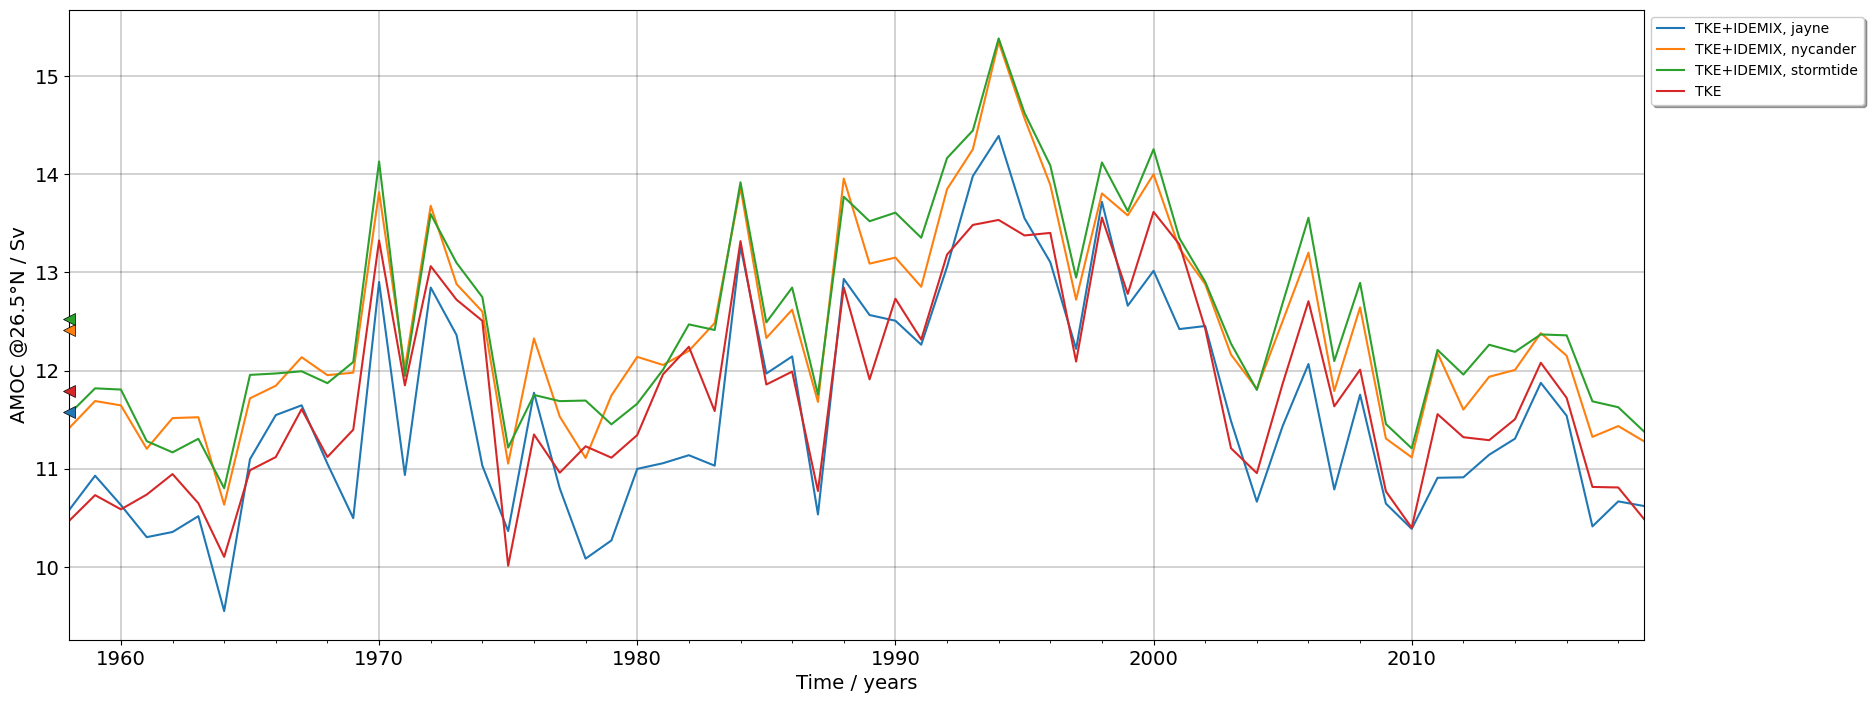

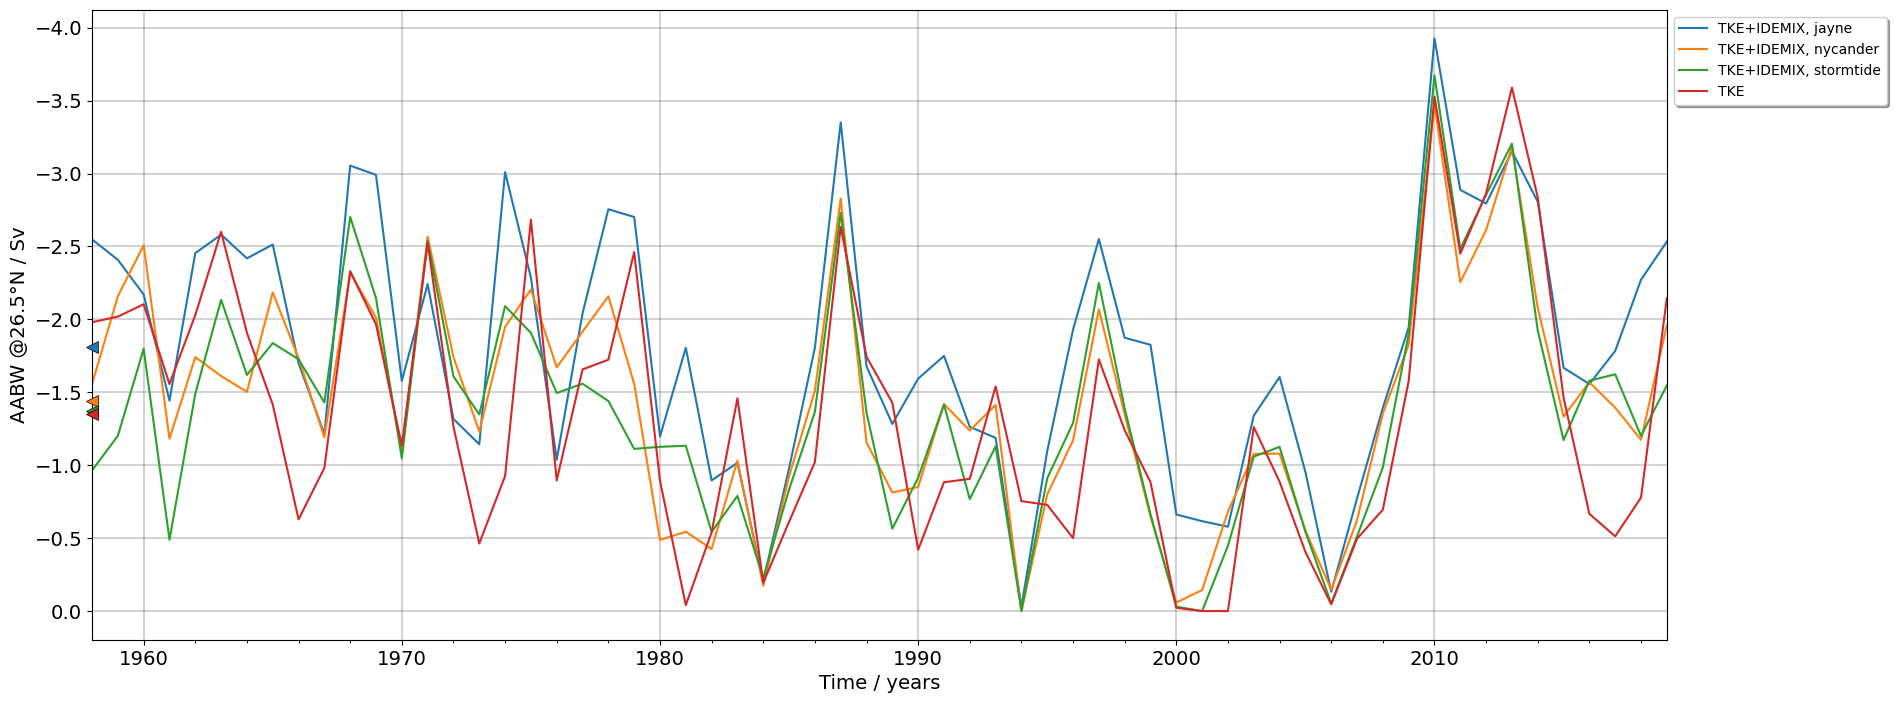

In [42]:
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
for lat in which_lat: 
    lat_list = list()
    for data in data_list:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_nadw','zmoc_ucell']:
                data_lat = data[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                lat_list.append([data_lat])        
        
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    slabel = lat_list[0][0][svname].attrs['str_lsave']
    stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zmoc_t_ucell', stname ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            do_enum    = do_enum                 ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )            

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
for lat in which_lat: 
    lat_list = list()
    for data in data_list:
        for var in data.data_vars:
            #_______________________________________________________________
            if var in ['zmoc_aabw','zmoc_lcell']:
                data_lat = data[var].to_dataset(promote_attrs=True)
                if lat=='max':
                    data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).min(dim='lat') 
                    str_label= f'@{40}°N<lat<{60}°N'
                elif isinstance(lat, list):    
                    data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                    str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                else:     
                    data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                    if lat>=0: str_label= f'@{lat}°N'
                    else     : str_label= f'@{lat}°S'  
                data_lat[var].attrs['add2ylabel'] = str_label
                data_lat[var].attrs['short_name'] = 'AABW'
                data_lat[var].attrs['long_name']  = 'AABW'
                lat_list.append([data_lat])        
        
    #___PLOT TRANSECT__________________________________________________________________________________
    svname = list(lat_list[0][0].data_vars)[0]
    slabel = lat_list[0][0][svname].attrs['str_lsave']
    stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zmoc_t_lcell', stname ,slabel, sfmt)) )

    #__________________________________________________________________________________________________
    fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                            n_cycl     = n_cycl                  , 
                            do_allcycl = do_allcycl              , 
                            do_concat  = do_concat               , 
                            do_shdw    = do_shdw                 ,
                            do_mean    = do_mean                 ,
                            do_std     = do_std                  ,
                            ax_opt     = dict({'fig_sizefac':4}) ,
                            grid_opt   = dict({'do_yinvert':True}),
                            do_enum    = do_enum                  ,
                            do_save    = sfpath, save_dpi=save_dpi, 
                         )